# **Исследование протокола Token Ring**

Исследуются харрактеристики протокола Token Ring, измеряемые на различных реализациях протокола, проводятся количественный и сравнительный анализы

# **Цели и задачи:**

**Цель:** Провести комплексное исследование протокола обозначить возможные пути оптимизации

**Задачи:**

1.   Сделать первичную реализацию протокола, испотльзуя модель сети без задержек на узлах
2.   Измерить latency и throughput в зависимости от размера буфера на сетях с разной загрузкой 
3.   Смоделировать сеть с постоянной задержкой на отправку сообщения на ноде (токен обрабатывается за время t=const)
4.   Сделать выводы об оптимальном размере буфферов для различных типов нагрузки, а так же различных размеров колец 
***Дополнительно:***
5.    Сделать выводы о влиянии количества нод на характеристики
6.    Сделать сравнение сети с буффером и без в ключевых моментах

# **Модель**

*   Компьютер: 2,6 ГГц, 6‑ядерный Intel Core i7, ускорение Turbo Boost до 4,5 ГГц, 12 МБ кэш‑памяти третьего уровня, MacOS, 16 ГБ 2667 MHz DDR4
*   Количество поддерживаемых потоков: 12
*  Реализации token ring: https://github.com/Nikitos-U/Concurrency-tokenRing
*   Эксперименты проводятся на сетях с разной загрузкой: (сообщения составляют: 10%, 50%, 80% от совокупного размера всех буфферов)
*   Кольцо состоит из 10 узлов (обоснование см. эксперимент №1)


*   *latency* - измеряется как время доставки сообщения от точки входа, до наиболее удаленного узла в системе 
*   *throughput* - измеряется как количество сообщений, которые способен обработать узел в единицу времени

# **Эксперименты**



1.   **Выбор количества узлов для тестирования:**

Все дальнейшие эксперименты проводятся на кольце, содержащем в себе 10 узлов. Выбор именно такого количества обоснован измерениями (см график ниже).
Т.к. количество реальных ядер на процессоре = 6, количество hyperthreading ядер = 6 => максимальное количество поддерживаемых потоков = 12, однако при использовании 12 узлов (не говоря уже о 16 на которых измерения так же проводились) в измерениях наблюдаются сильные флуктуации (вплоть до 3х порядков). Исходя из указанного выше, за оптимальную была принята сеть из 10 узлов: сеть достаточно большая для того, чтобы измерения времени не уходили в область малых значений, и достаточно маленькая для того, чтобы помимо работы самого протокола, ОС могла поддерживать необходимые для функционирования потоки. 







In [162]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as patches

node_num_latencies = pd.read_csv('ringSizeResults.csv', delimiter=",")

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


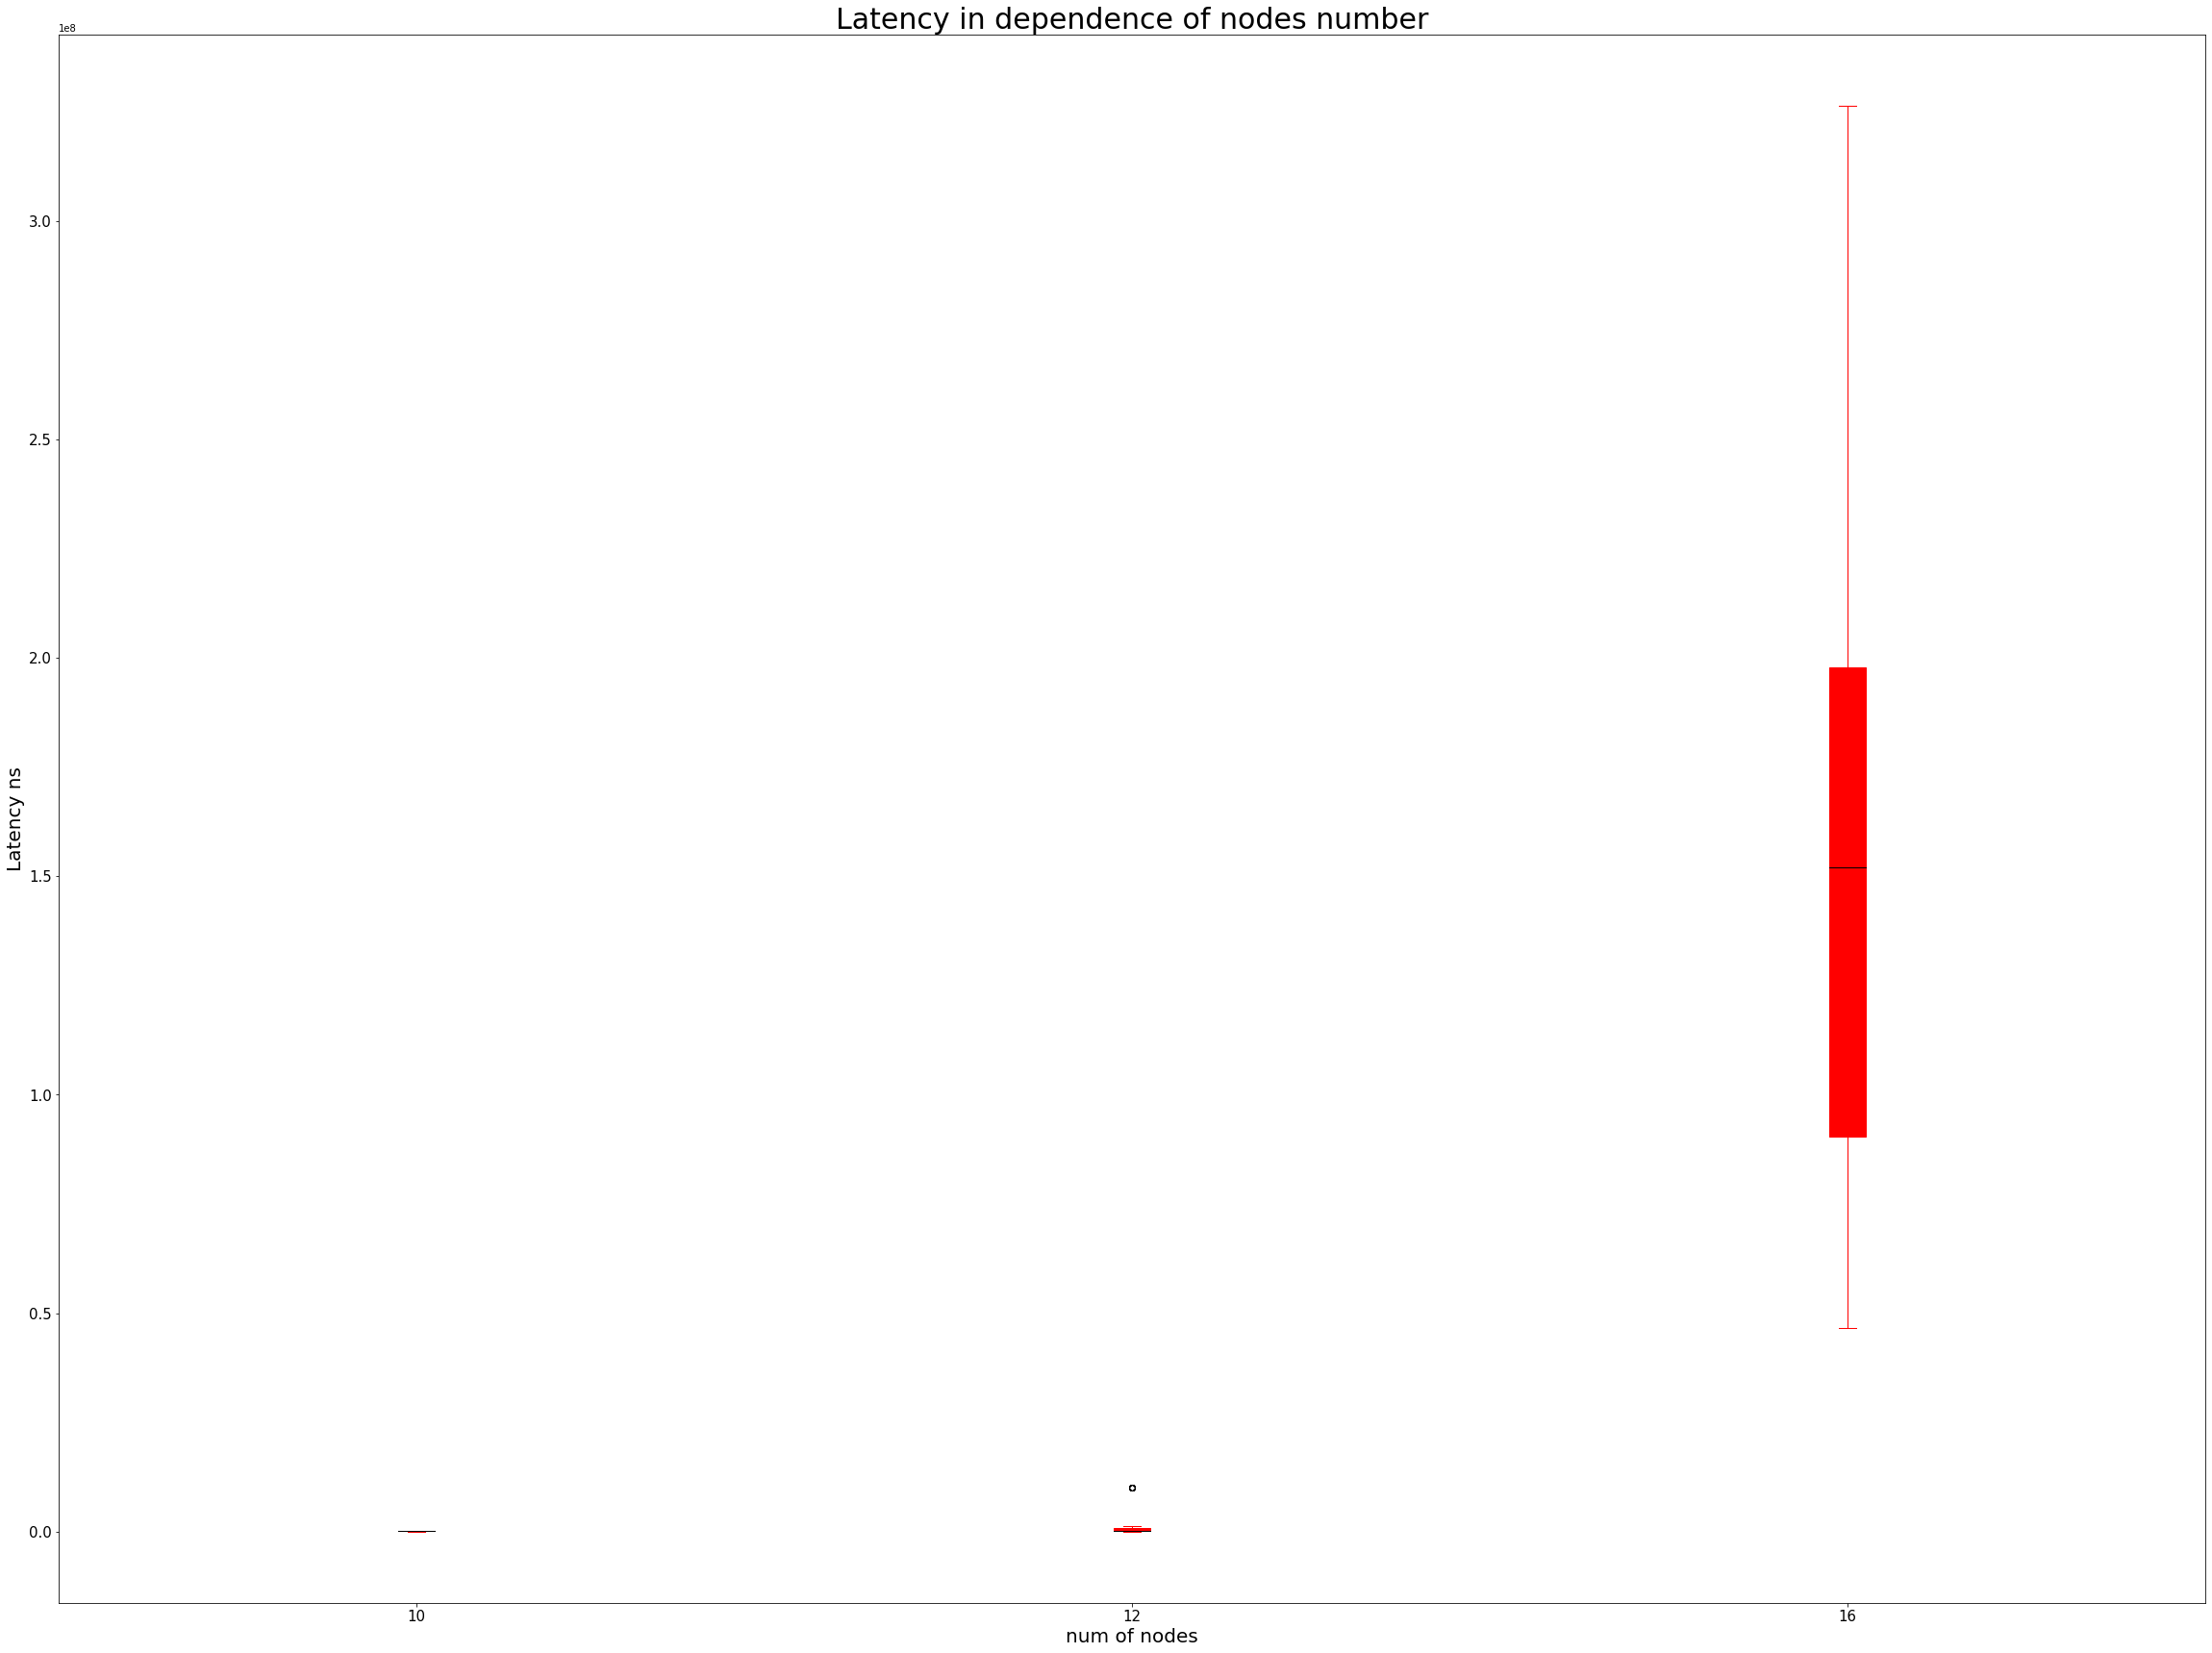

In [166]:
def draw_plot(data, edge_color, fill_color, offset):
    bp = ax.boxplot(data, positions = [1 + offset, 2 + offset, 3 + offset], widths=0.05, patch_artist=True, labels= [10, 12, 16]) 
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
        plt.setp(bp[element], color=edge_color)
    plt.setp(bp['medians'], color = 'black')
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color) 
    plt.xlabel('num of nodes', fontsize = 20)
    plt.ylabel('Latency ns', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.title( 'Latency in dependence of nodes number', fontsize = 30)  

fig, ax = plt.subplots(figsize=(40,30))
plot_10_nodes = node_num_latencies[' latency ns'][node_num_latencies['num of nodes'] == 10]
plot_12_nodes = node_num_latencies[' latency ns'][node_num_latencies['num of nodes'] == 12]
plot_16_nodes = node_num_latencies[' latency ns'][node_num_latencies['num of nodes'] == 16]
draw_plot([plot_10_nodes.values, plot_12_nodes.values, plot_16_nodes.values], 'red', 'red', -0.2)

2.    **Измерения на сети с изменяемой искуственной задержкой в узлах**

**Модель:**

Используется реализация протокола token ring с использованием blockingQueue из пакета cuncurrency в java. Между каждыми двумя узлами в сети находятся очереди - медиумы, через которые данные узлы и осуществляют трансфер сообщений. Данная реализация рассмотривается с позиции изменения размера буффера (5, 10, 20, 50 сообщений), а так же различных уровней нагрузки в сети (10%, 50% и 80% сообщений от общего объема всех буфферов). Так же на каждом узле может быть добавленна искуственная постоянная задержка на обработку сообщения (0, 2, 10 ms), что позволяет моделировать медленную работу узлов по обработке сообщения.

In [167]:
latencies = pd.read_csv('queueWithArtificialLatencyTest.csv', delimiter=",")

In [168]:
latencies = latencies.dropna()
latencies = latencies.astype('int')
latencies.head(1000)

,buffer size,load %,const latency ms,latency ns
0,10,10,0,0
1,10,10,0,141382
2,10,10,0,104031
3,10,10,0,79162
4,10,10,0,94112
...,...,...,...,...
995,50,10,0,194029
996,50,10,0,89291
997,50,10,0,124249
998,50,10,0,174546


Измерения без постоянной задержки:

In [169]:
plot10_10_0 = latencies[' latency ns'][(latencies['buffer size'] == 10) & (latencies[' load %'] == 10) & (latencies[' const latency ms'] == 0)]
plot20_10_0 = latencies[' latency ns'][(latencies['buffer size'] == 20) & (latencies[' load %'] == 10) & (latencies[' const latency ms'] == 0)]
plot50_10_0 = latencies[' latency ns'][(latencies['buffer size'] == 50) & (latencies[' load %'] == 10) & (latencies[' const latency ms'] == 0)]
plot10_50_0 = latencies[' latency ns'][(latencies['buffer size'] == 10) & (latencies[' load %'] == 50) & (latencies[' const latency ms'] == 0)]
plot20_50_0 = latencies[' latency ns'][(latencies['buffer size'] == 20) & (latencies[' load %'] == 50) & (latencies[' const latency ms'] == 0)]
plot50_50_0 = latencies[' latency ns'][(latencies['buffer size'] == 50) & (latencies[' load %'] == 50) & (latencies[' const latency ms'] == 0)]
plot10_80_0 = latencies[' latency ns'][(latencies['buffer size'] == 10) & (latencies[' load %'] == 80) & (latencies[' const latency ms'] == 0)]
plot20_80_0 = latencies[' latency ns'][(latencies['buffer size'] == 20) & (latencies[' load %'] == 80) & (latencies[' const latency ms'] == 0)]
plot50_80_0 = latencies[' latency ns'][(latencies['buffer size'] == 50) & (latencies[' load %'] == 80) & (latencies[' const latency ms'] == 0)]
# latencies.columns

На граффике ниже видны зависимоси задержки от нагрузки в сети, а так же изменения задержки при увеличении размера буффера с сохранением процентной нагрузки на сеть.

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

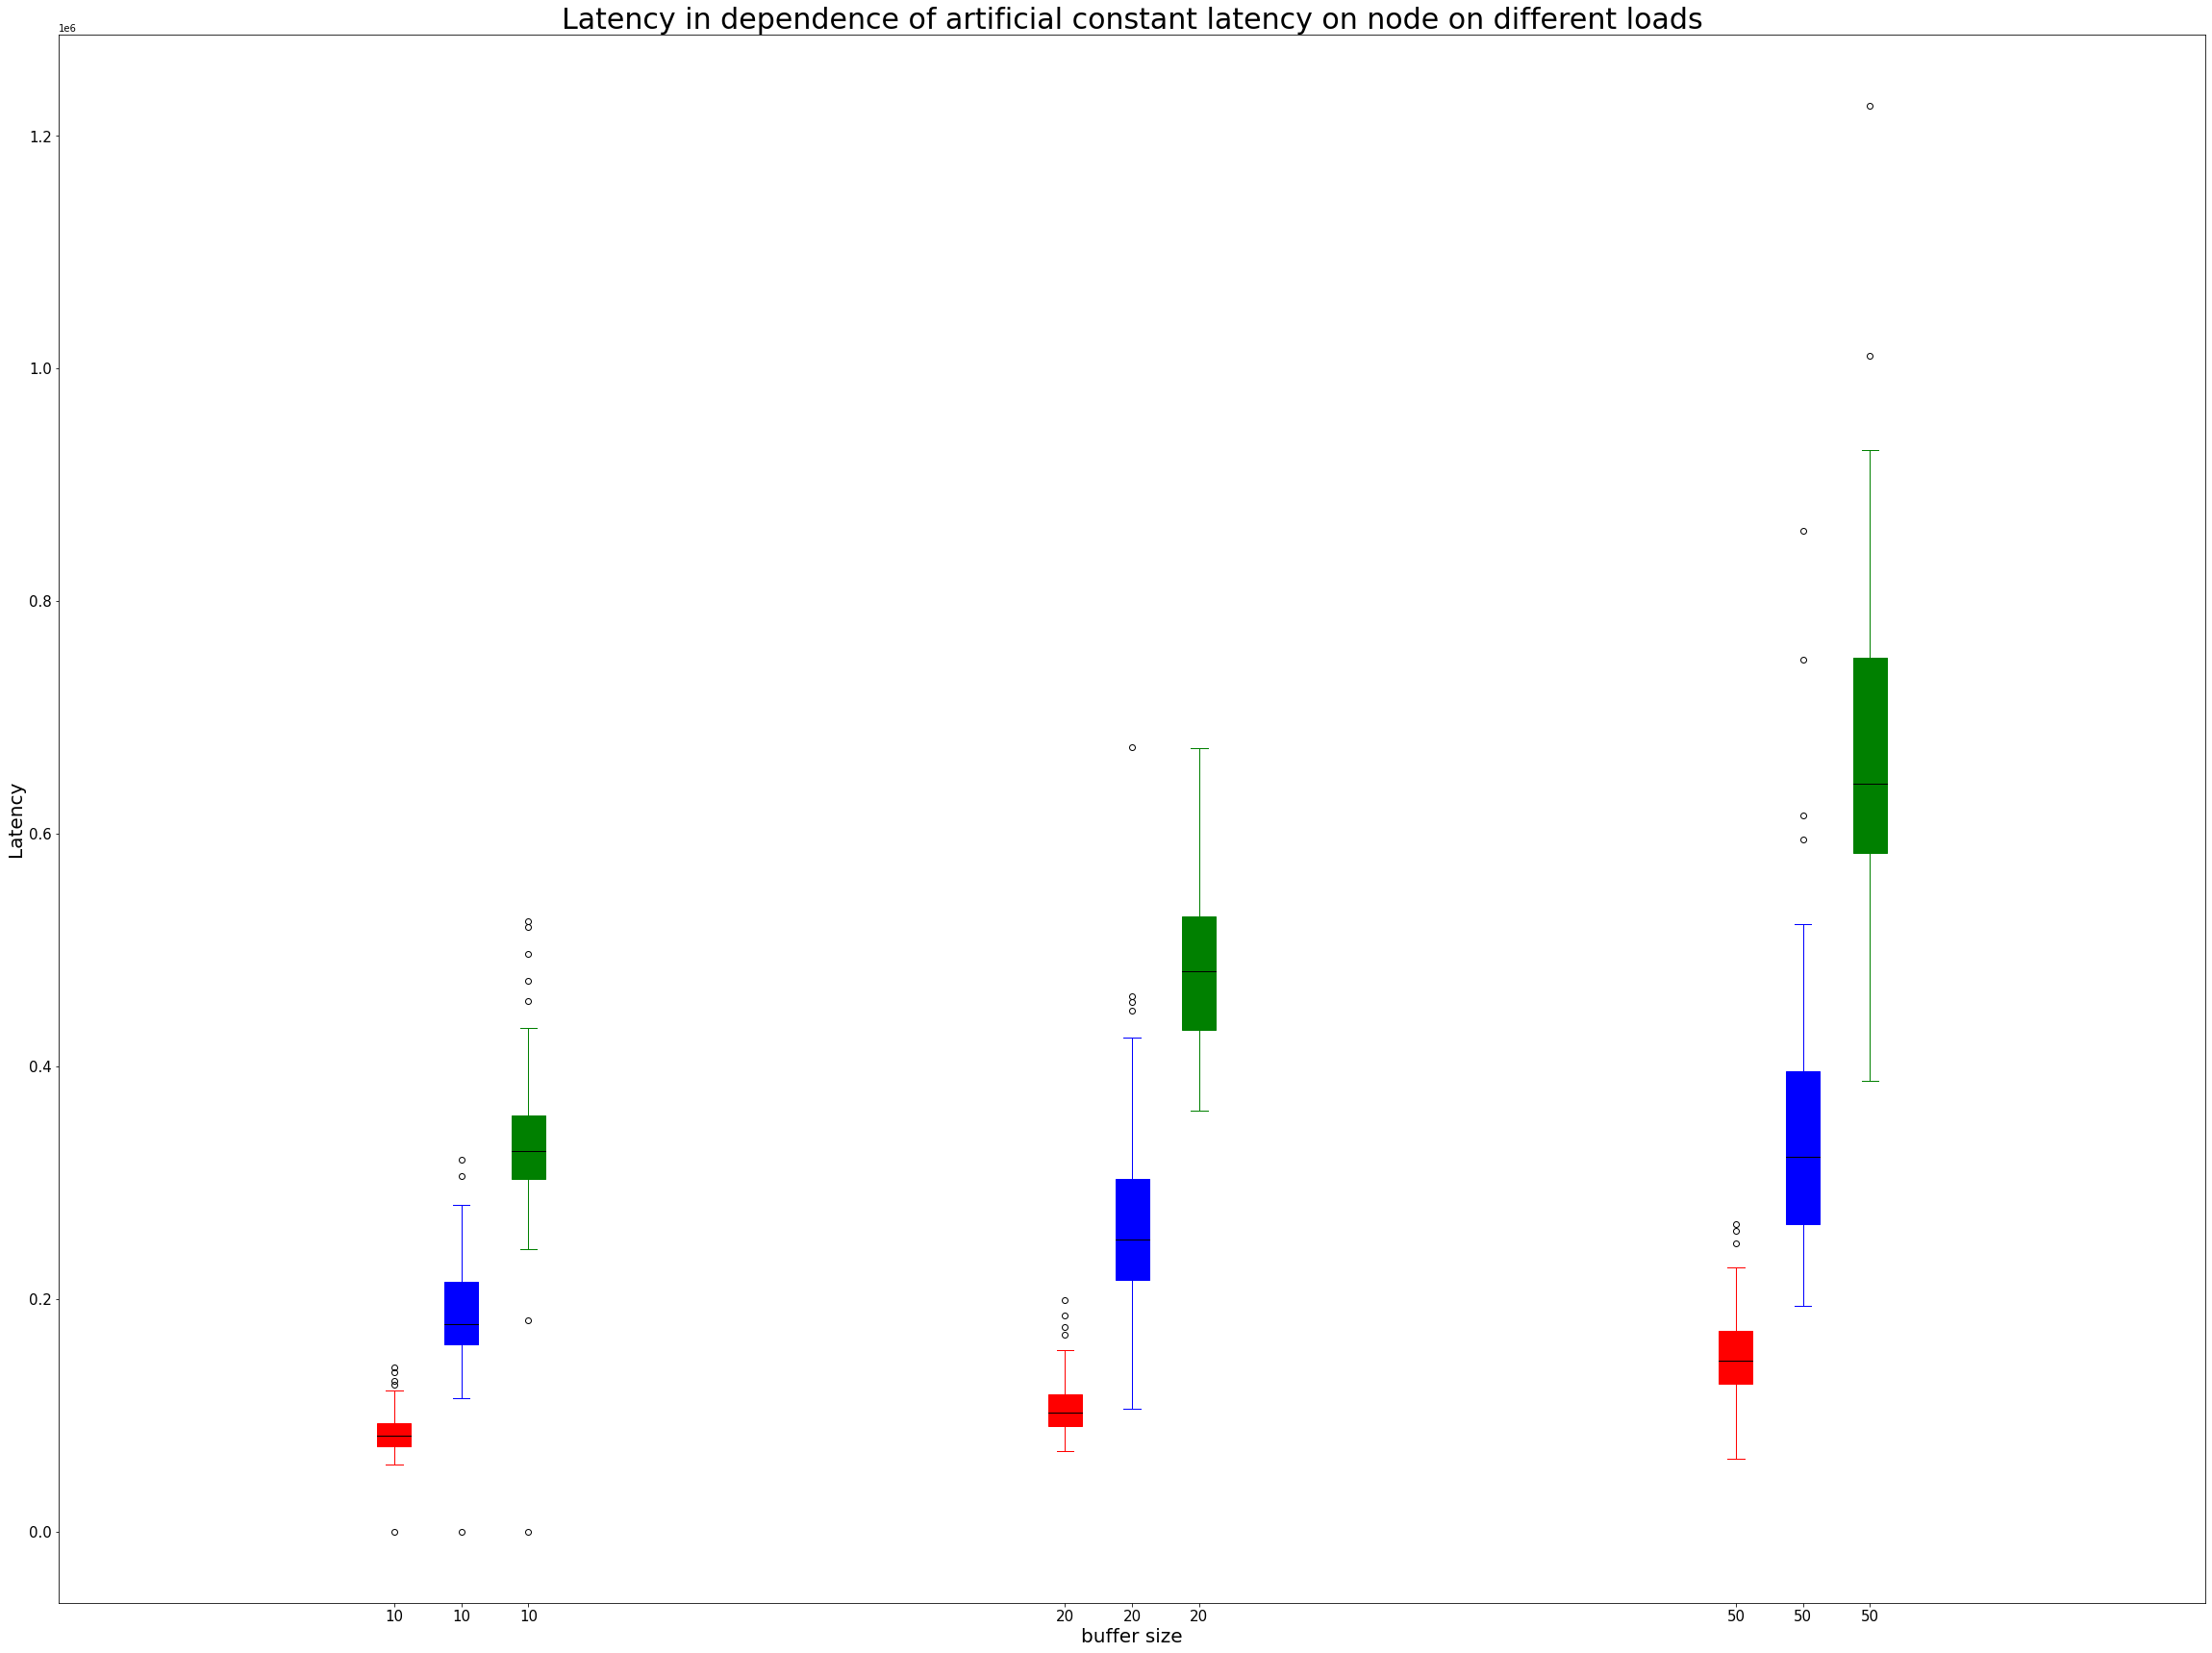

In [170]:
def draw_plot(data, edge_color, fill_color, offset):
    bp = ax.boxplot(data, positions = [1 + offset, 2 + offset, 3 + offset], widths=0.05, patch_artist=True, labels= [10, 20, 50]) 
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
        plt.setp(bp[element], color=edge_color)
    plt.setp(bp['medians'], color = 'black')
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color) 
    plt.xlabel('buffer size', fontsize = 20)
    plt.ylabel('Latency', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.title( 'Latency in dependence of artificial constant latency on node on different loads', fontsize = 30)   

fig, ax = plt.subplots(figsize=(40,30))
draw_plot([plot10_10_0.values, plot20_10_0.values, plot50_10_0.values], 'red', 'red', -0.2)
draw_plot([plot10_50_0.values, plot20_50_0.values, plot50_50_0.values], 'blue', 'blue', -0.1)
draw_plot([plot10_80_0.values, plot20_80_0.values, plot50_80_0.values], 'green', 'green', +0)

Видно, что с ростом нагрузки на сеть возрастает и latency. Абсолютные значения количества сообщений в системе можно компенсировать за счет увеличения размера буффера, однако тогда сеть сможет обрабатывать большее количество сообщений, и в таком случае при высокой нагрузке latency возрастает значительно

Одинаковые размер буффера и искусственная задержка, изменяем загрузку сети

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


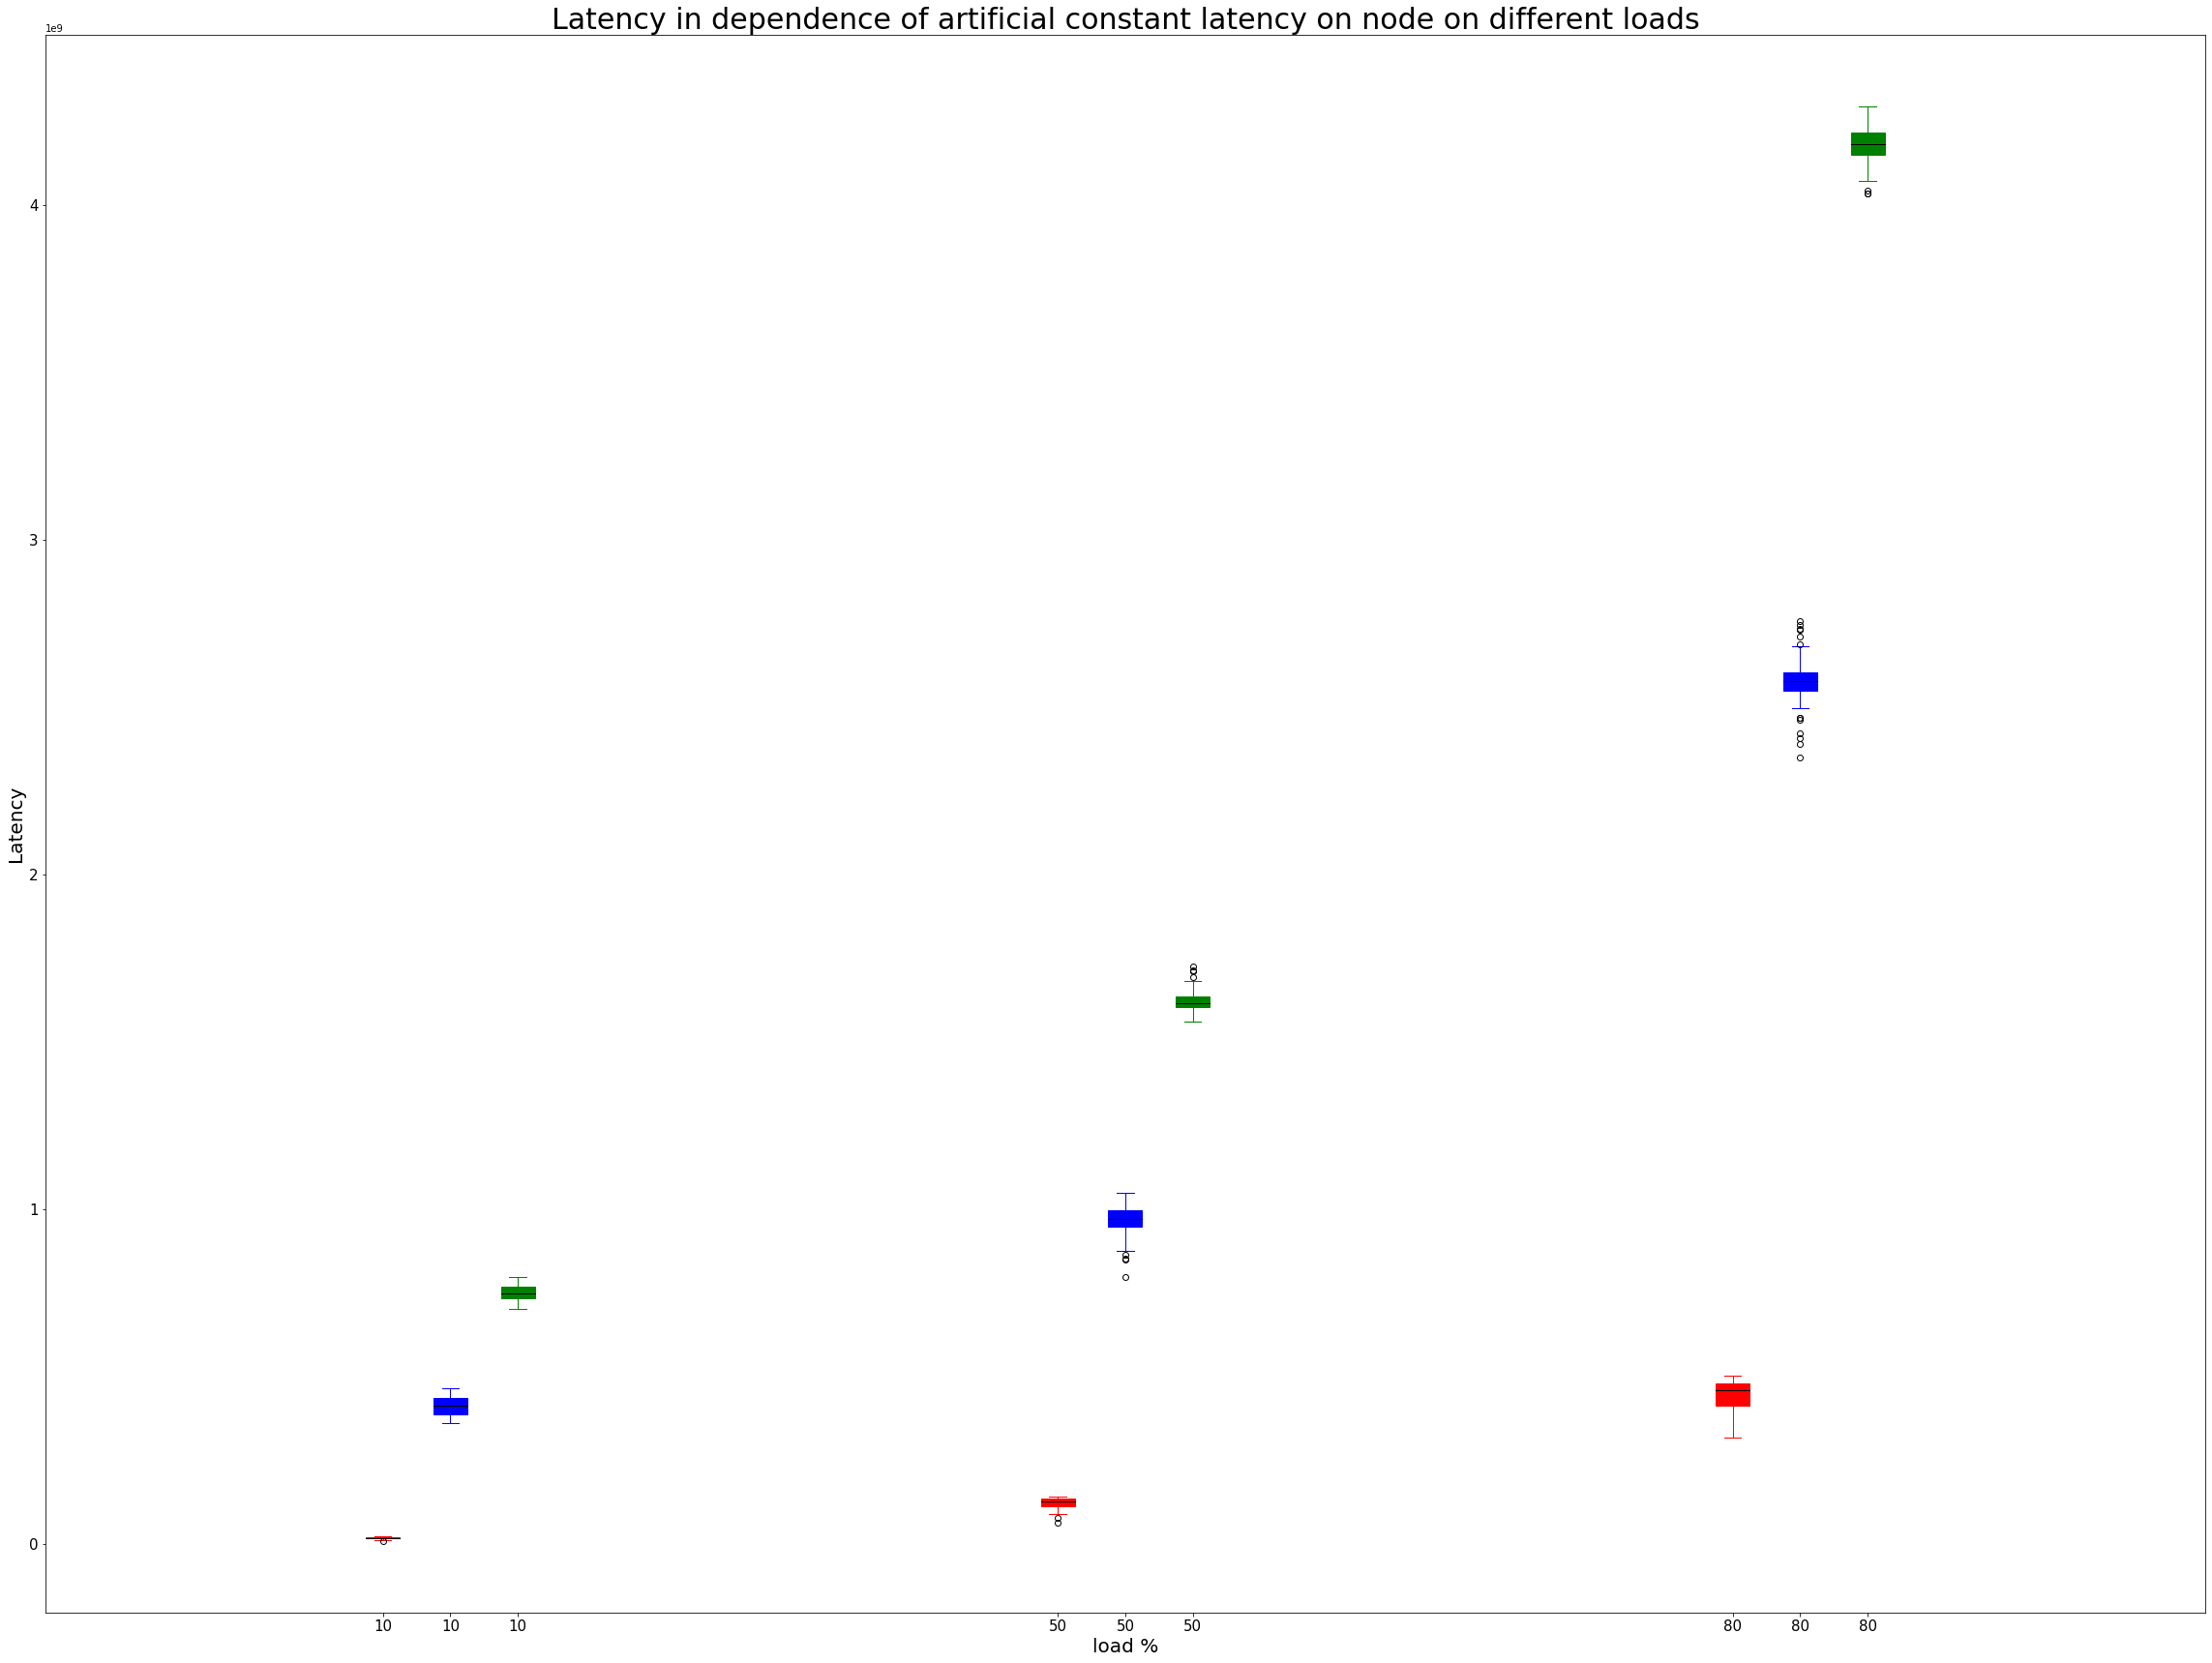

In [ ]:
plot10_10_10 = latencies[' latency ns'][(latencies['buffer size'] == 10) & (latencies[' load %'] == 10) & (latencies[' const latency ms'] == 10)]
plot10_50_10 = latencies[' latency ns'][(latencies['buffer size'] == 10) & (latencies[' load %'] == 50) & (latencies[' const latency ms'] == 10)]
plot10_80_10 = latencies[' latency ns'][(latencies['buffer size'] == 10) & (latencies[' load %'] == 80) & (latencies[' const latency ms'] == 10)]
plot20_10_10 = latencies[' latency ns'][(latencies['buffer size'] == 20) & (latencies[' load %'] == 10) & (latencies[' const latency ms'] == 10)]
plot20_50_10 = latencies[' latency ns'][(latencies['buffer size'] == 20) & (latencies[' load %'] == 50) & (latencies[' const latency ms'] == 10)]
plot20_80_10 = latencies[' latency ns'][(latencies['buffer size'] == 20) & (latencies[' load %'] == 80) & (latencies[' const latency ms'] == 10)]
plot50_10_10 = latencies[' latency ns'][(latencies['buffer size'] == 50) & (latencies[' load %'] == 10) & (latencies[' const latency ms'] == 10)]
plot50_50_10 = latencies[' latency ns'][(latencies['buffer size'] == 50) & (latencies[' load %'] == 50) & (latencies[' const latency ms'] == 10)]
plot50_80_10 = latencies[' latency ns'][(latencies['buffer size'] == 50) & (latencies[' load %'] == 80) & (latencies[' const latency ms'] == 10)]
def draw_plot(data, edge_color, fill_color, offset):
    bp = ax.boxplot(data, positions = [1 + offset, 2 + offset, 3 + offset], widths=0.05, patch_artist=True, labels= [10, 50, 80]) 
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
        plt.setp(bp[element], color=edge_color)
    plt.setp(bp['medians'], color = 'black')
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color) 
    plt.xlabel('load %', fontsize = 20)
    plt.ylabel('Latency', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.title( 'Latency in dependence of artificial constant latency on node on different loads', fontsize = 30) 
  
fig, ax = plt.subplots(figsize=(40,30))
draw_plot([plot10_10_10.values, plot20_10_10.values, plot50_10_10.values], 'red', 'red', -0.2)
draw_plot([plot10_50_10.values, plot20_50_10.values, plot50_50_10.values], 'blue', 'blue', -0.1)
draw_plot([plot10_80_10.values, plot20_80_10.values, plot50_80_10.values], 'green', 'green', +0)

Аналогично, latency возрастает при увеличении нагрузки на сеть, однако, хорошо видно, что замедление обработки нодами сообщений вносит существенный вклад и сильно влияет на прирост характеристики. При этом увеличение размера буффера не является хорошим решением, так как не помогает ослабить прирост latency.

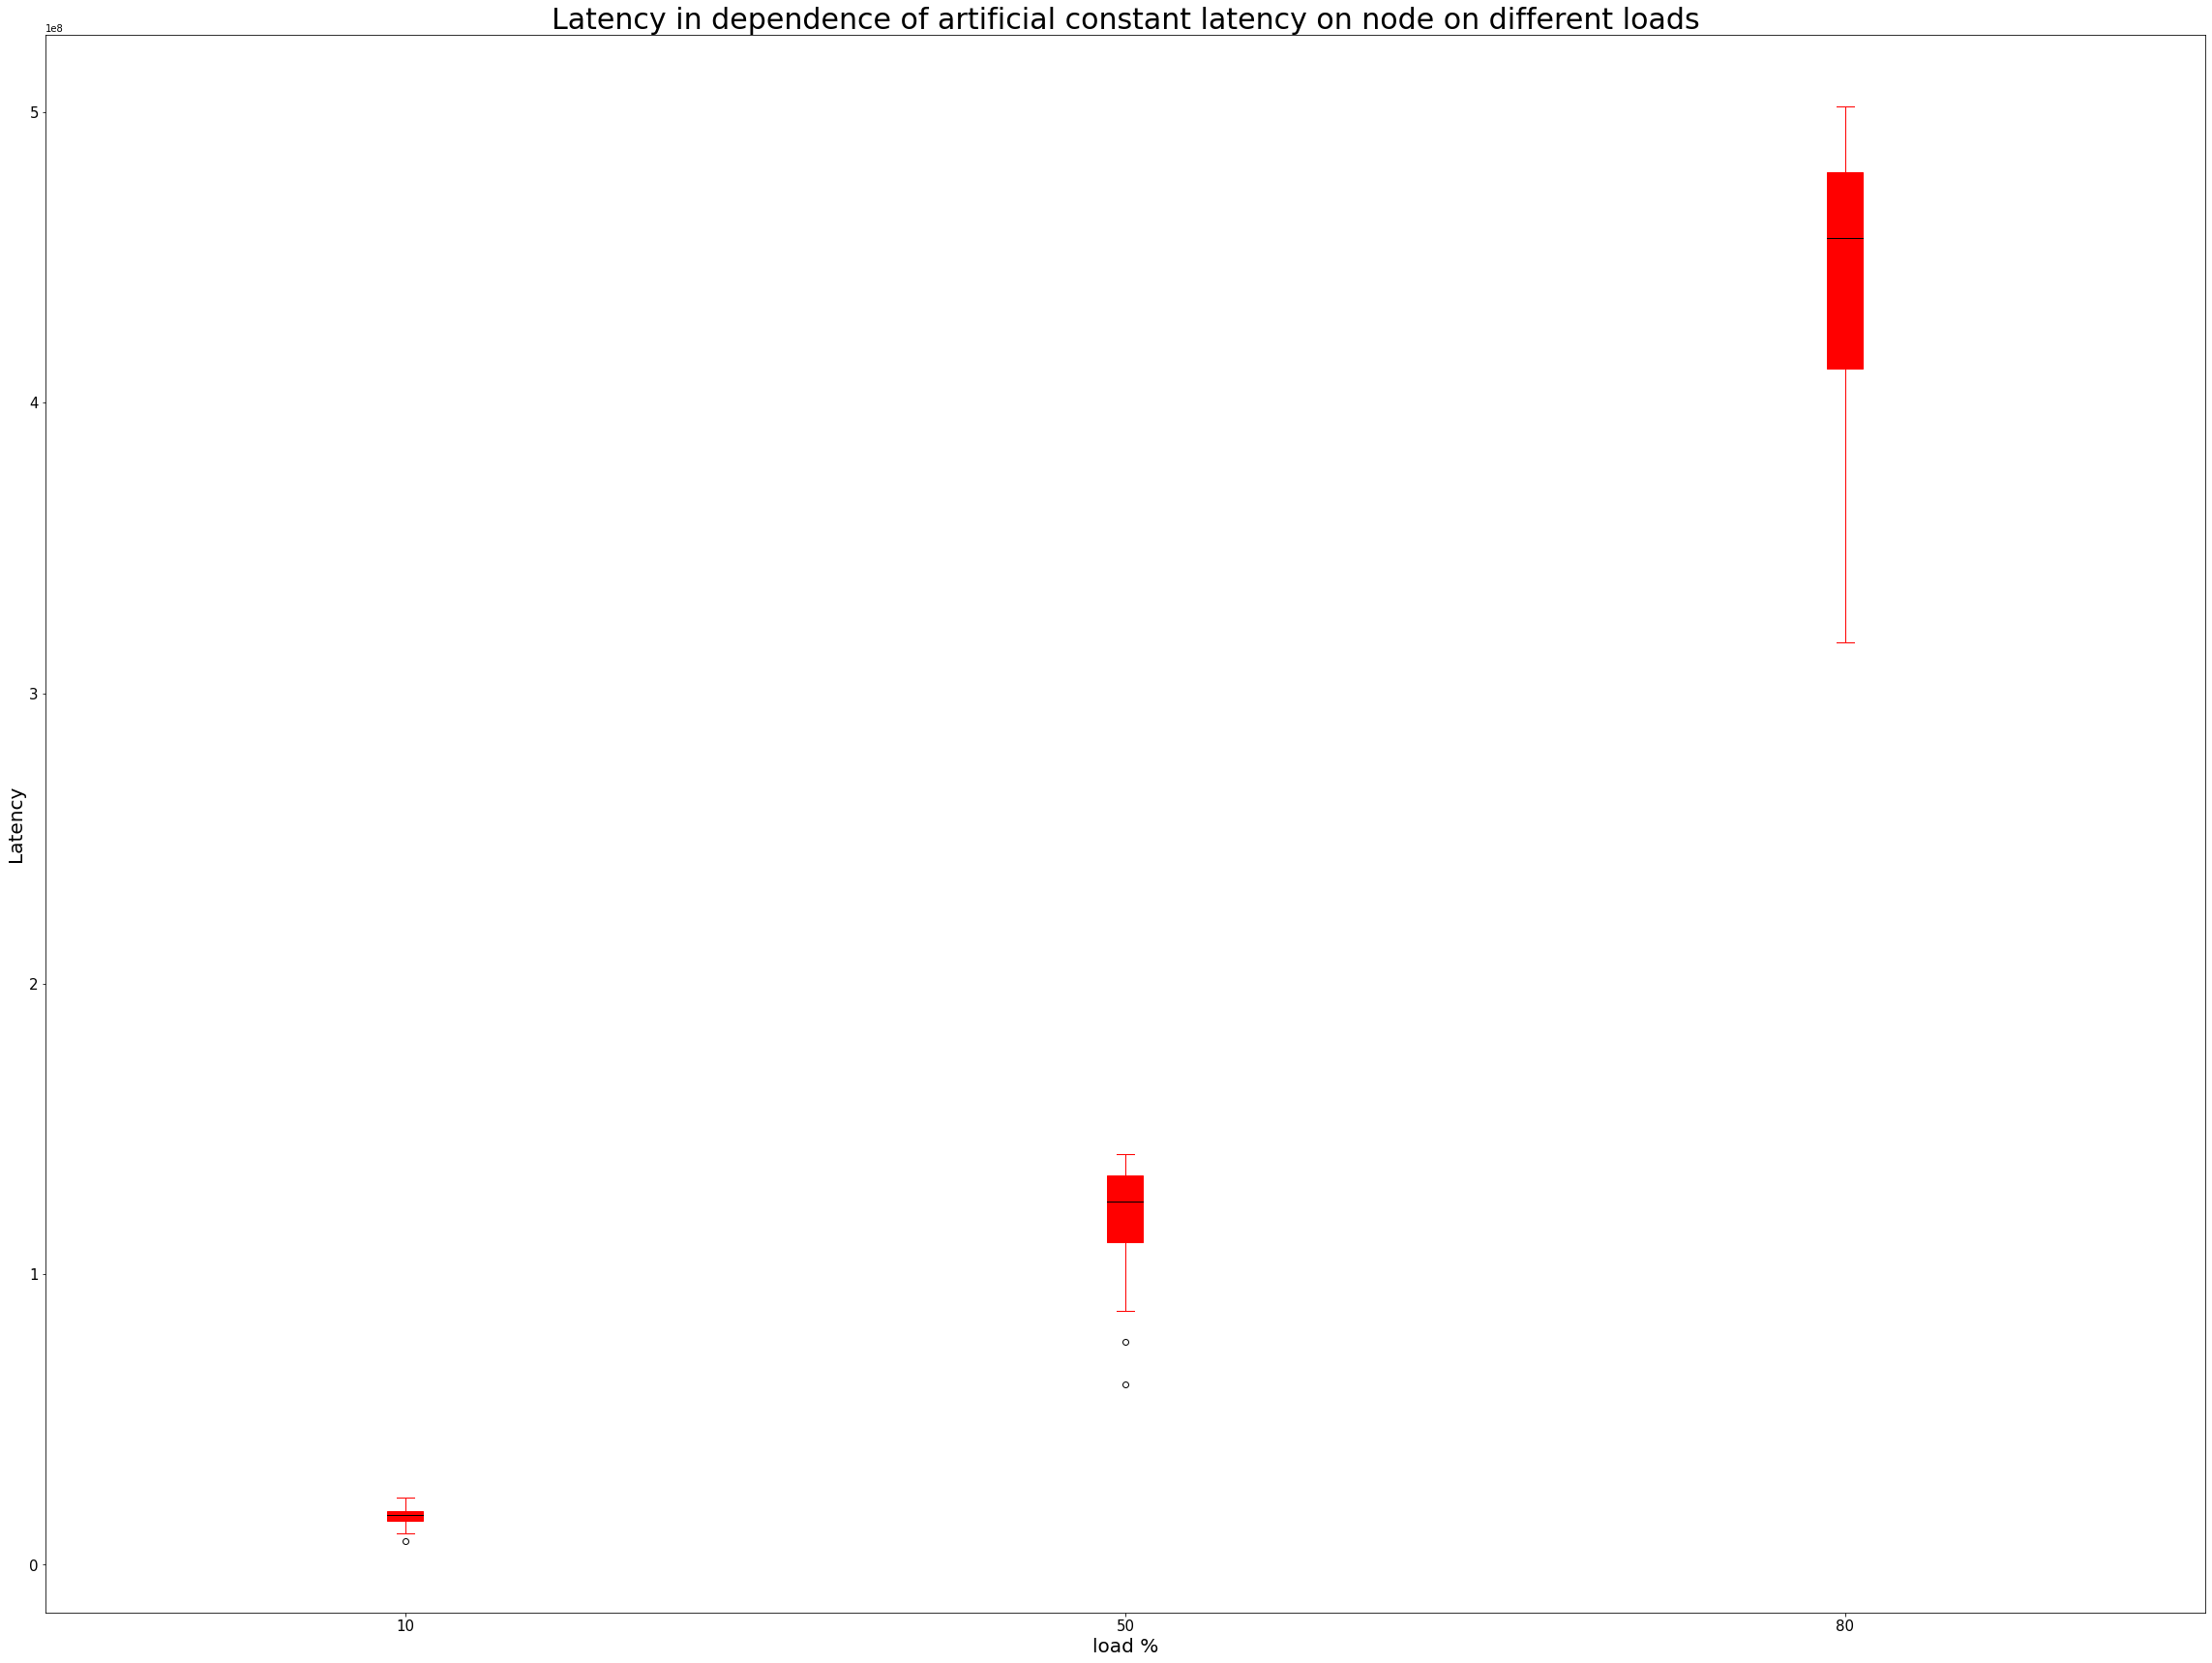

In [ ]:
fig, ax = plt.subplots(figsize=(40,30))
draw_plot([plot10_10_10.values, plot20_10_10.values, plot50_10_10.values], 'red', 'red', -0.2)

**Задержка в зависимости от количства сообщений**

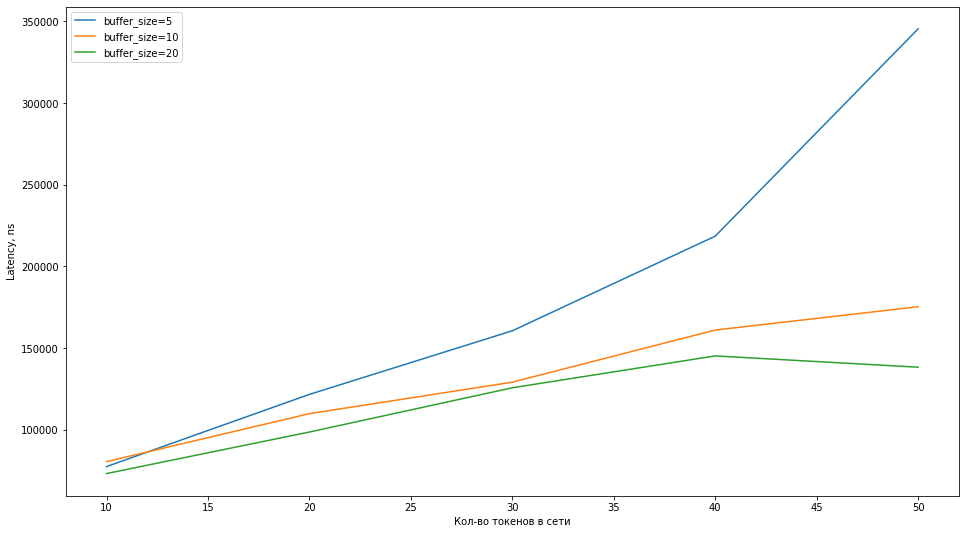

In [ ]:
latencies_on_token_num = pd.read_csv('latencyOnTokensNumberTest.csv', delimiter=",")


def avg_latencies(buffer_size, const_latency, tokens_num):
    all_latencies = []
    for i in range(10, tokens_num * 10, 10):
      tmp = latencies_on_token_num[' latency ns'][(latencies_on_token_num['buffer size'] == buffer_size) & (latencies_on_token_num[' const latency ms'] == const_latency) & (latencies_on_token_num[' number of tokens'] == i)]   
      all_latencies.append(np.mean(tmp.values))
    return all_latencies

avg_latency_5 = avg_latencies(5, 0, 6)
avg_latency_10 = avg_latencies(10, 0, 6)
avg_latency_20 = avg_latencies(20, 0, 6)


fig = plt.figure(figsize=(16, 9))
plt.plot(range(10, 60, 10), avg_latency_5, label="buffer_size=5")
plt.plot(range(10, 60, 10), avg_latency_10, label="buffer_size=10")
plt.plot(range(10, 60, 10), avg_latency_20, label="buffer_size=20")
plt.title("")
plt.xlabel("Кол-во токенов в сети")
plt.ylabel("Latency, ns")
plt.legend()
plt.show()

Рассматриваются системы с тремя раличными размерами буфферов в медиумах. Искусственная задержка на узлах отсутсвует. Видно, что в случае, когда абсолютное количество сообщений в системе велико буффер помогает снизить латенси (что просто объясняется тем, что очереди не простаивают в заполненном состоянии). Однако при малой (относительно буффера) нагрузке, размер очереди не вносит существенных отличий

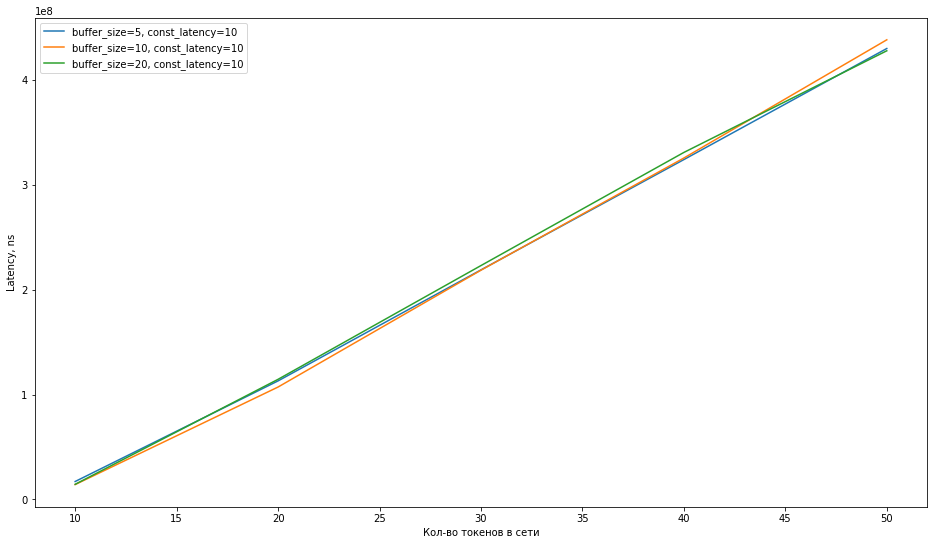

In [ ]:
avg_latency_5_10 = avg_latencies(5, 10, 6)
avg_latency_10_10 = avg_latencies(10, 10, 6)
avg_latency_20_10 = avg_latencies(20, 10, 6)
fig = plt.figure(figsize=(16, 9))
plt.plot(range(10, 60, 10), avg_latency_5_10, label="buffer_size=5, const_latency=10")
plt.plot(range(10, 60, 10), avg_latency_10_10, label="buffer_size=10, const_latency=10")
plt.plot(range(10, 60, 10), avg_latency_20_10, label="buffer_size=20, const_latency=10")
plt.title("")
plt.xlabel("Кол-во токенов в сети")
plt.ylabel("Latency, ns")
plt.legend()
plt.show()

В случае наличия в узлах задержки при обработке сообщений, из графика видно,  хоть сколько-нибудь существенного отличия в скорости доставки сообщения нет. Скорее всего, в данном случае наибольшую роль играет наличие или отсутствие очереди в системе, а не её размер.

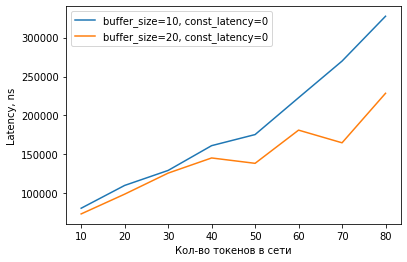

In [ ]:
avg_latency_10_0_8 = avg_latencies(10, 0, 9)
avg_latency_20_0_8 = avg_latencies(20, 0, 9)
plt.plot(range(10, 90, 10), avg_latency_10_0_8, label="buffer_size=10, const_latency=0")
plt.plot(range(10, 90, 10), avg_latency_20_0_8, label="buffer_size=20, const_latency=0")
plt.title("")
plt.xlabel("Кол-во токенов в сети")
plt.ylabel("Latency, ns")
plt.legend()
plt.show()

3.   Измерения throughput:

Аналогично измерениям latency, рассматривается пропускная способность узлов в зависимости от размеров очередей, а так же нагрузки, в условиях медленной и быстрой обработки сообщений узлами.

In [ ]:
throughputs = pd.read_csv('queueWithArtificialLatencyThroughputTest.csv', delimiter=",")

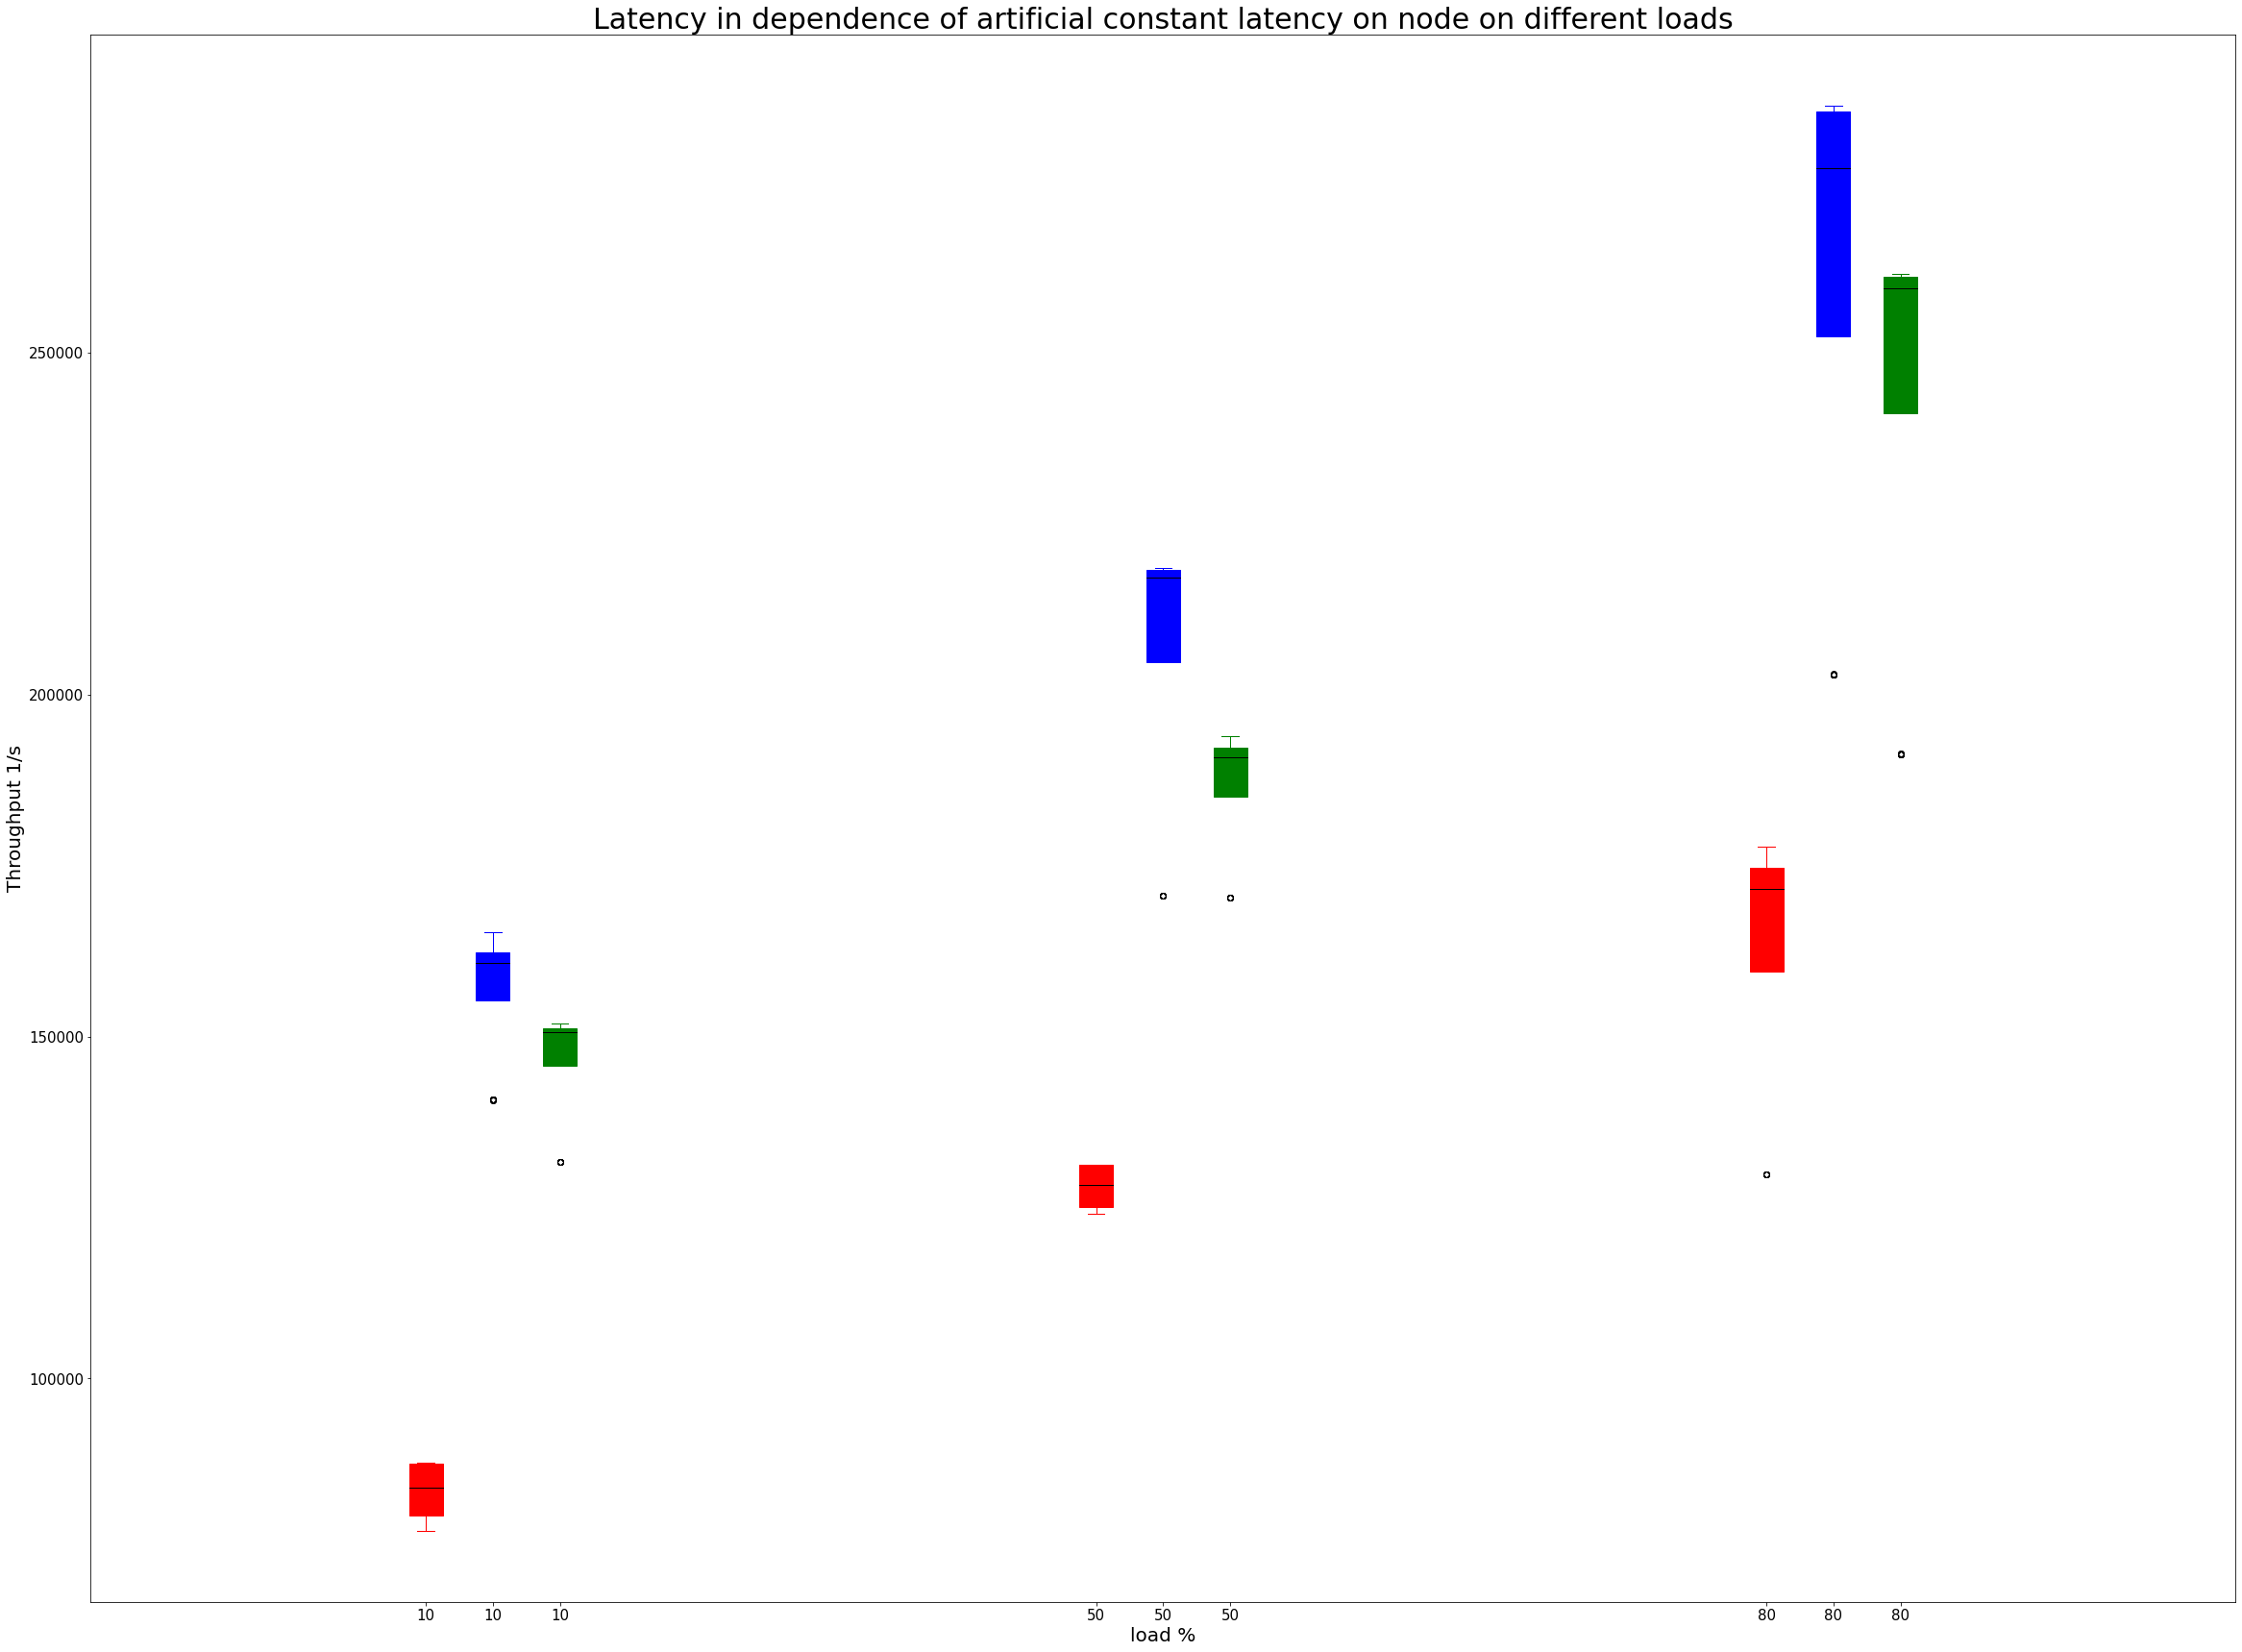

In [ ]:
plot10_10_0 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 10) & (throughputs[' load %'] == 10) & (throughputs[' const latency ms'] == 0)]
plot10_50_0 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 10) & (throughputs[' load %'] == 50) & (throughputs[' const latency ms'] == 0)]
plot10_80_0 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 10) & (throughputs[' load %'] == 80) & (throughputs[' const latency ms'] == 0)]
plot20_10_0 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 20) & (throughputs[' load %'] == 10) & (throughputs[' const latency ms'] == 0)]
plot20_50_0 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 20) & (throughputs[' load %'] == 50) & (throughputs[' const latency ms'] == 0)]
plot20_80_0 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 20) & (throughputs[' load %'] == 80) & (throughputs[' const latency ms'] == 0)]
plot50_10_0 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 50) & (throughputs[' load %'] == 10) & (throughputs[' const latency ms'] == 0)]
plot50_50_0 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 50) & (throughputs[' load %'] == 50) & (throughputs[' const latency ms'] == 0)]
plot50_80_0 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 50) & (throughputs[' load %'] == 80) & (throughputs[' const latency ms'] == 0)]

def draw_plot(data, edge_color, fill_color, offset):
    bp = ax.boxplot(data, positions = [1 + offset, 2 + offset, 3 + offset], widths=0.05, patch_artist=True, labels= [10, 50, 80]) 
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
        plt.setp(bp[element], color=edge_color)
    plt.setp(bp['medians'], color = 'black')
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color) 
    plt.xlabel('load %', fontsize = 20)
    plt.ylabel('Throughput 1/s', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.title( 'Latency in dependence of artificial constant latency on node on different loads', fontsize = 30) 
  
fig, ax = plt.subplots(figsize=(40,30))
draw_plot([plot10_10_0.values, plot20_10_0.values, plot50_10_0.values], 'red', 'red', -0.2)
draw_plot([plot10_50_0.values, plot20_50_0.values, plot50_50_0.values], 'blue', 'blue', -0.1)
draw_plot([plot10_80_0.values, plot20_80_0.values, plot50_80_0.values], 'green', 'green', +0)

В отсутствии искуственной задержки на узлах сети пропускная способность зависит от нагрузки и заполнености очередей на медиумах. При этом throughput существенно растет в диапазоне нагрузок 10 - 50 % от общего объема очередей, и, очевидно, снижается к 80% нагрузке, что сведетельствует о том, что очереди заполнены сильнее, чем было бы оптимально для систем. При условии сохранения абсолютного количества сообщений в сети имеет смысл увелчние размера очередей.

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


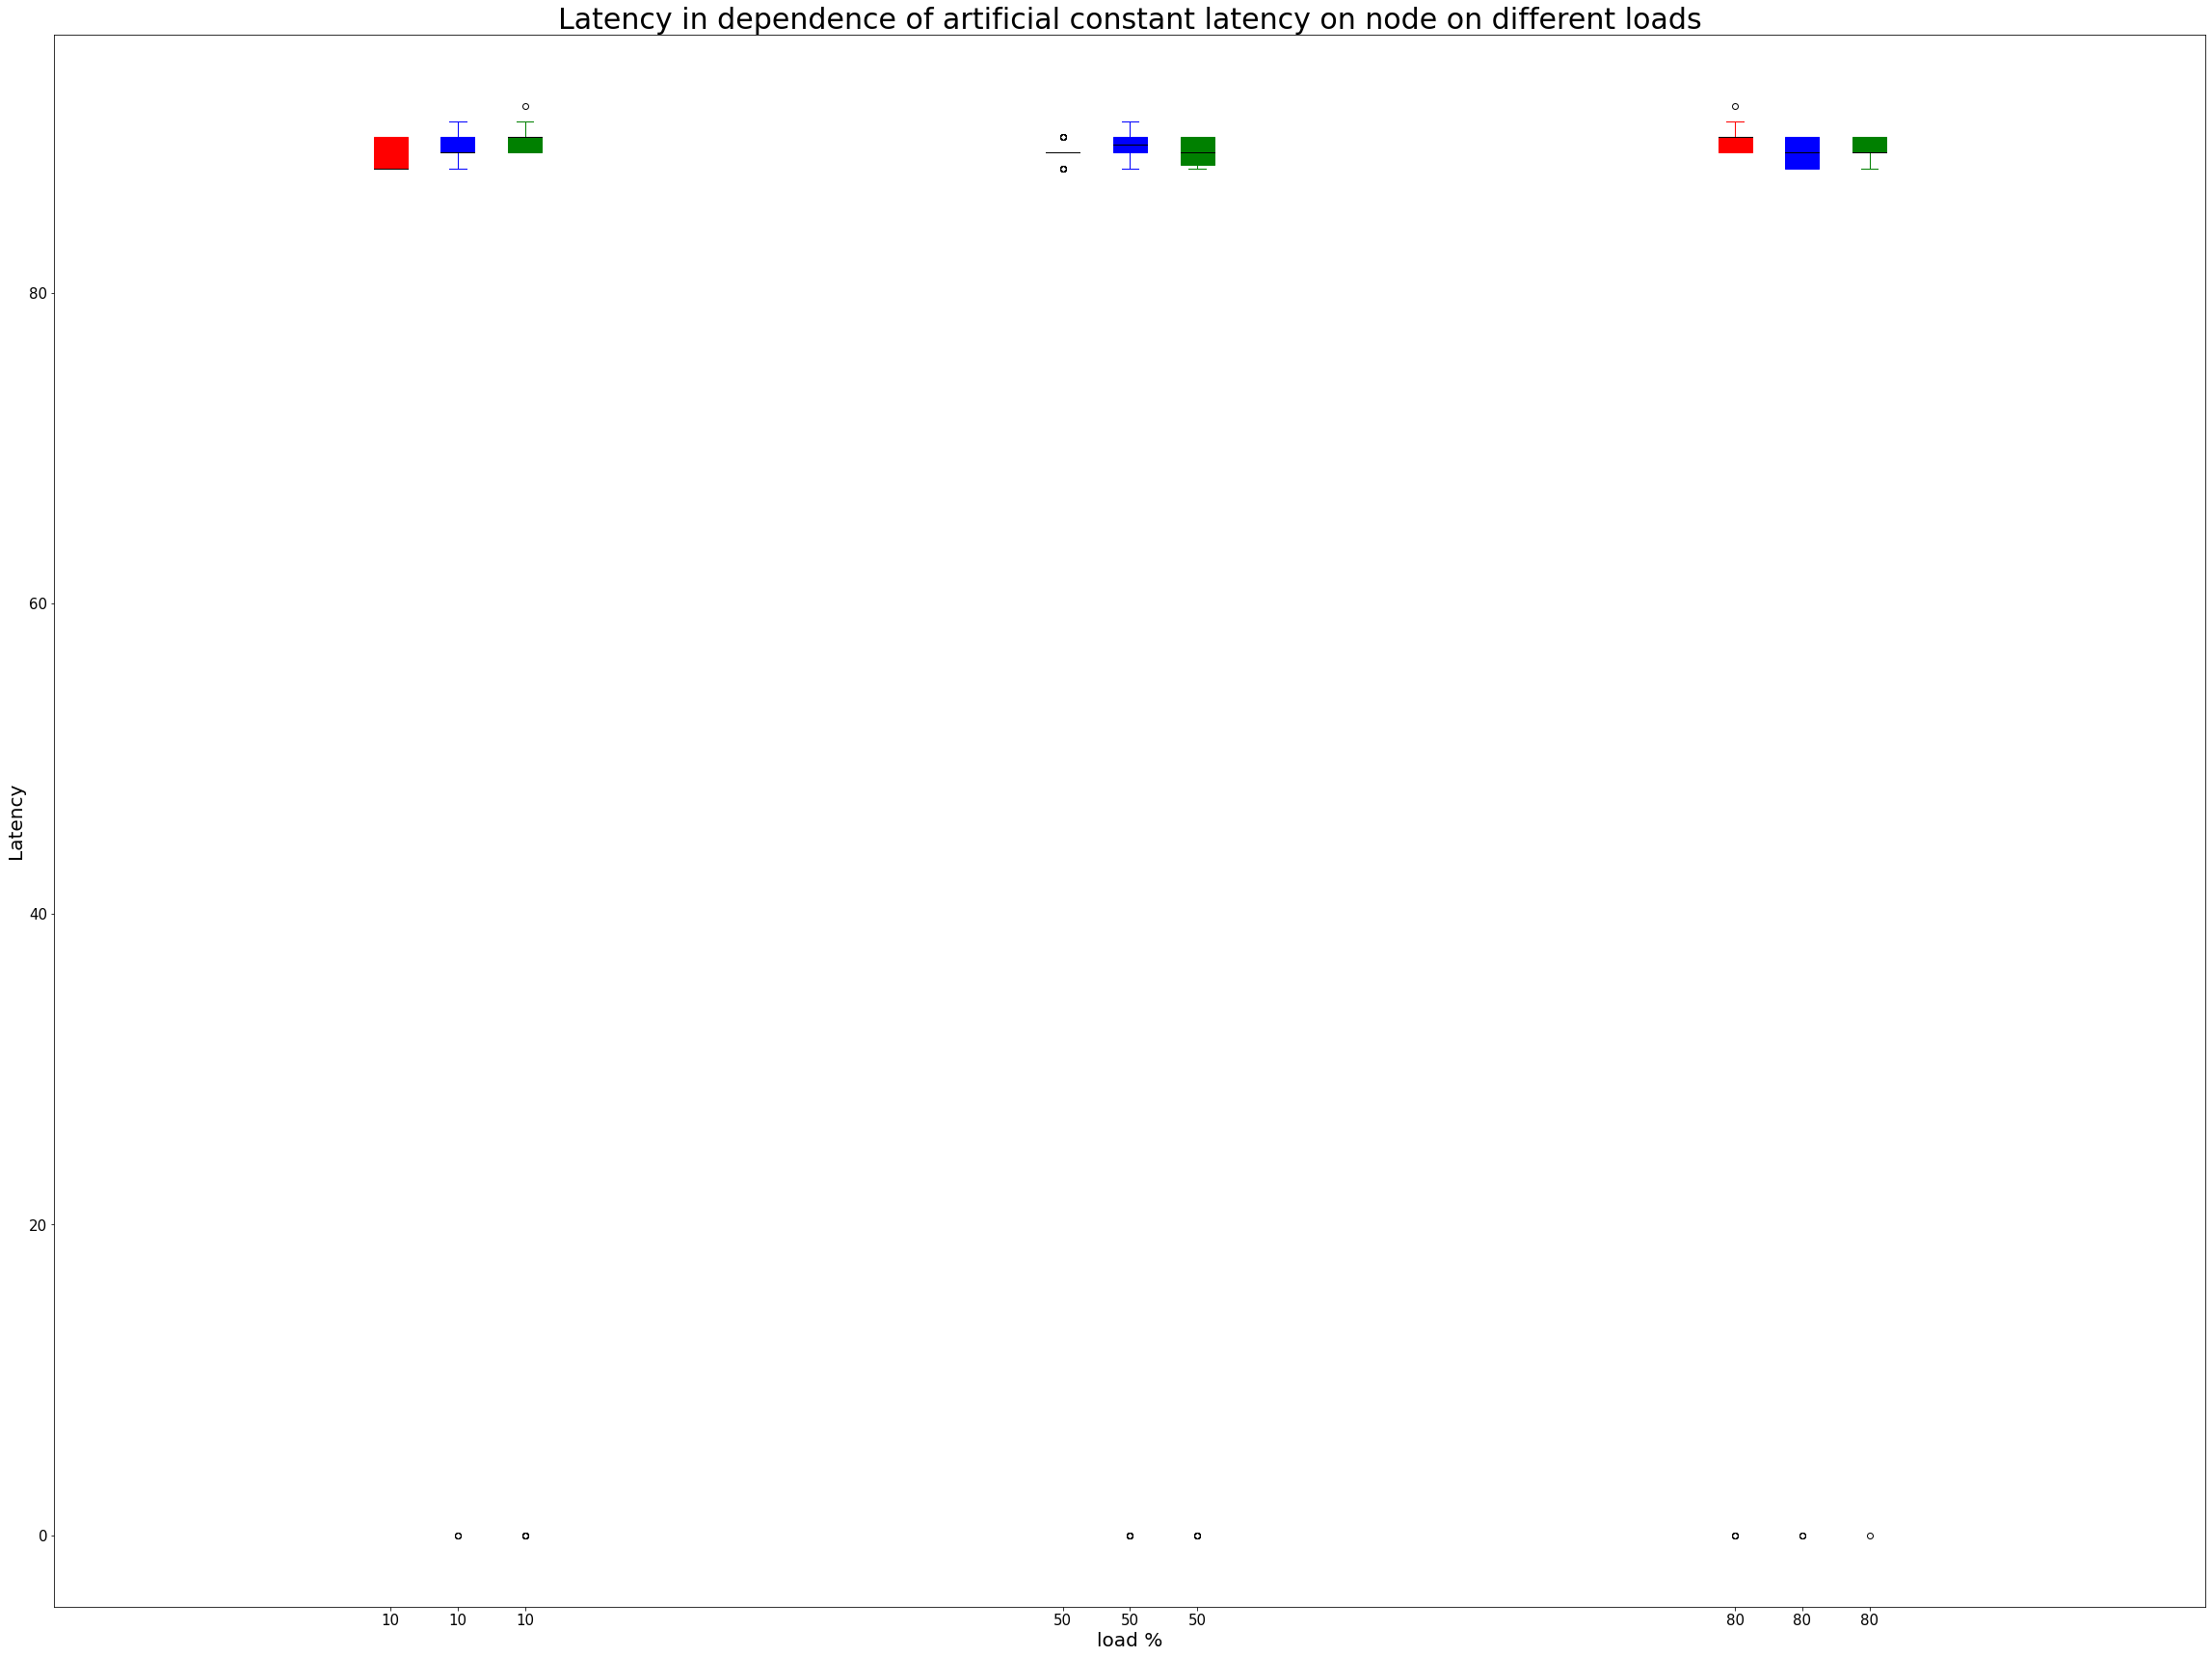

In [ ]:
plot10_10_10 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 10) & (throughputs[' load %'] == 10) & (throughputs[' const latency ms'] == 10)]
plot10_50_10 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 10) & (throughputs[' load %'] == 50) & (throughputs[' const latency ms'] == 10)]
plot10_80_10 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 10) & (throughputs[' load %'] == 80) & (throughputs[' const latency ms'] == 10)]
plot20_10_10 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 20) & (throughputs[' load %'] == 10) & (throughputs[' const latency ms'] == 10)]
plot20_50_10 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 20) & (throughputs[' load %'] == 50) & (throughputs[' const latency ms'] == 10)]
plot20_80_10 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 20) & (throughputs[' load %'] == 80) & (throughputs[' const latency ms'] == 10)]
plot50_10_10 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 50) & (throughputs[' load %'] == 10) & (throughputs[' const latency ms'] == 10)]
plot50_50_10 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 50) & (throughputs[' load %'] == 50) & (throughputs[' const latency ms'] == 10)]
plot50_80_10 = throughputs[' throughput 1/s'][(throughputs['buffer size'] == 50) & (throughputs[' load %'] == 80) & (throughputs[' const latency ms'] == 10)]

def draw_plot(data, edge_color, fill_color, offset):
    bp = ax.boxplot(data, positions = [1 + offset, 2 + offset, 3 + offset], widths=0.05, patch_artist=True, labels= [10, 50, 80]) 
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
        plt.setp(bp[element], color=edge_color)
    plt.setp(bp['medians'], color = 'black')
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color) 
    plt.xlabel('load %', fontsize = 20)
    plt.ylabel('Latency', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.title( 'Latency in dependence of artificial constant latency on node on different loads', fontsize = 30) 
  
fig, ax = plt.subplots(figsize=(40,30))
draw_plot([plot10_10_10.values, plot20_10_10.values, plot50_10_10.values], 'red', 'red', -0.2)
draw_plot([plot10_50_10.values, plot20_50_10.values, plot50_50_10.values], 'blue', 'blue', -0.1)
draw_plot([plot10_80_10.values, plot20_80_10.values, plot50_80_10.values], 'green', 'green', +0)

Как видно из граффика выше - даже 10 ms задержка на узлах ниверлирует положительные эффекты от размеров буффера и маленькой нагрузки, изменение данных параметров позволит лишь немного улучшить характеристики. В данной ситуации имеется острая необходимость поиска возможности ускорения работы самих узлов.

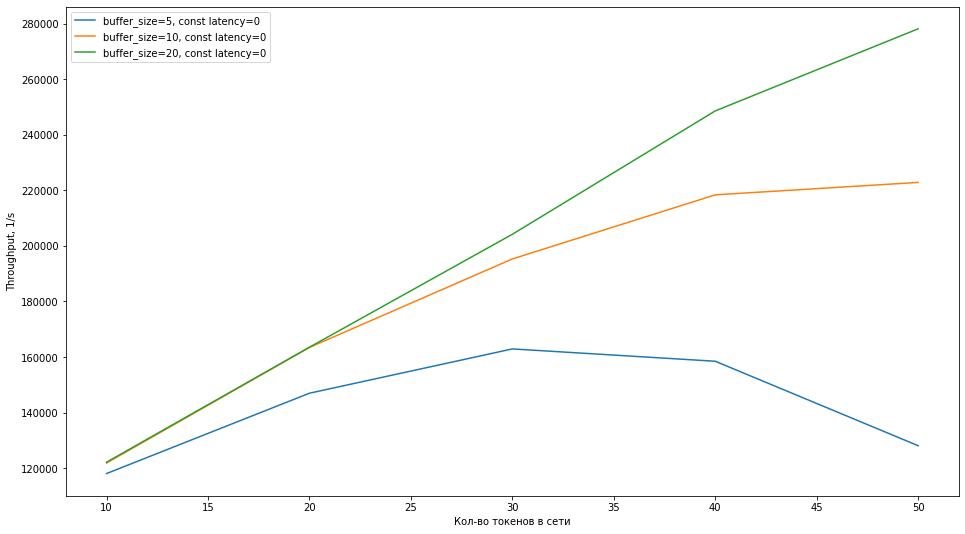

In [148]:
tput_on_token_num = pd.read_csv('throughputOnTokensNumberTest.csv', delimiter=",")


def avg_tputs(buffer_size, const_latency, tokens_num):
    all_tputs = []
    for i in range(10, tokens_num * 10, 10):
      tmp = tput_on_token_num[' throughput 1/s'][(tput_on_token_num['buffer size'] == buffer_size) & (tput_on_token_num[' const latency ms'] == const_latency) & (tput_on_token_num[' number of tokens'] == i)]   
      all_tputs.append(np.mean(tmp.values))
    return all_tputs

avg_tput_5 = avg_tputs(5, 0, 6)
avg_tput_10 = avg_tputs(10, 0, 6)
avg_tput_20 = avg_tputs(20, 0, 6)


fig = plt.figure(figsize=(16, 9))
plt.plot(range(10, 60, 10), avg_tput_5, label="buffer_size=5, const latency=0")
plt.plot(range(10, 60, 10), avg_tput_10, label="buffer_size=10, const latency=0")
plt.plot(range(10, 60, 10), avg_tput_20, label="buffer_size=20, const latency=0")
plt.title("")
plt.xlabel("Кол-во токенов в сети")
plt.ylabel("Throughput, 1/s")
plt.legend()
plt.show()

Рассмтривается throughput в зависимости от количества сообщений в системах с различными размерами буфферов, в отсутсвии искуственной задержки в узлах. Видно, что системы, не достигшие высокой нагрузки (по абсолютному количеству сообщений в системе) успевают отправить значительно большее количество сообщений, в то время как системы с маленькими очередями переходят через пик характристики. Следовательно, в случае сохранения количества сообщений можно получть лучшую производительность за счет увеличения размеров очередей.

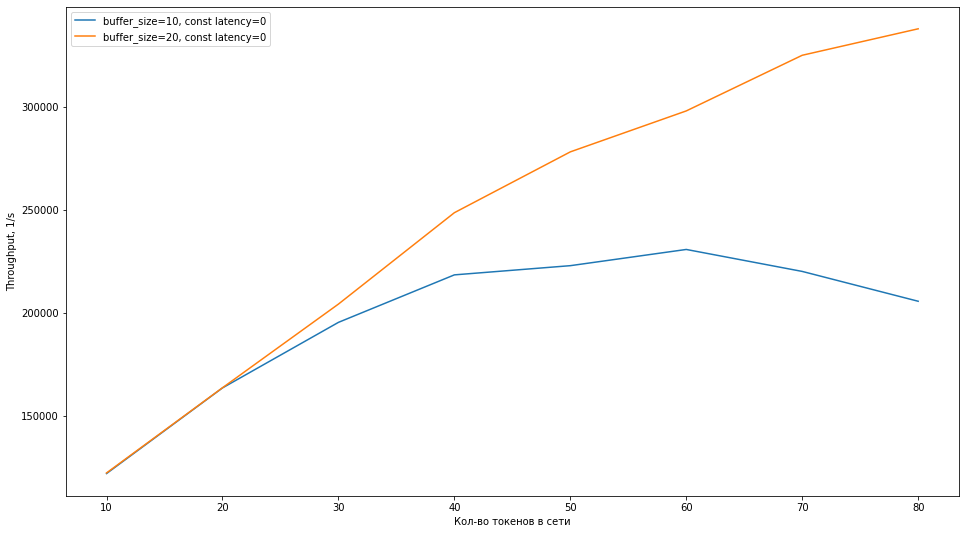

In [152]:
avg_tput_10_0 = avg_tputs(10, 0, 9)
avg_tput_20_0 = avg_tputs(20, 0, 9)


fig = plt.figure(figsize=(16, 9))
plt.plot(range(10, 90, 10), avg_tput_10_0, label="buffer_size=10, const latency=0")
plt.plot(range(10, 90, 10), avg_tput_20_0, label="buffer_size=20, const latency=0")
plt.title("")
plt.xlabel("Кол-во токенов в сети")
plt.ylabel("Throughput, 1/s")
plt.legend()
plt.show()

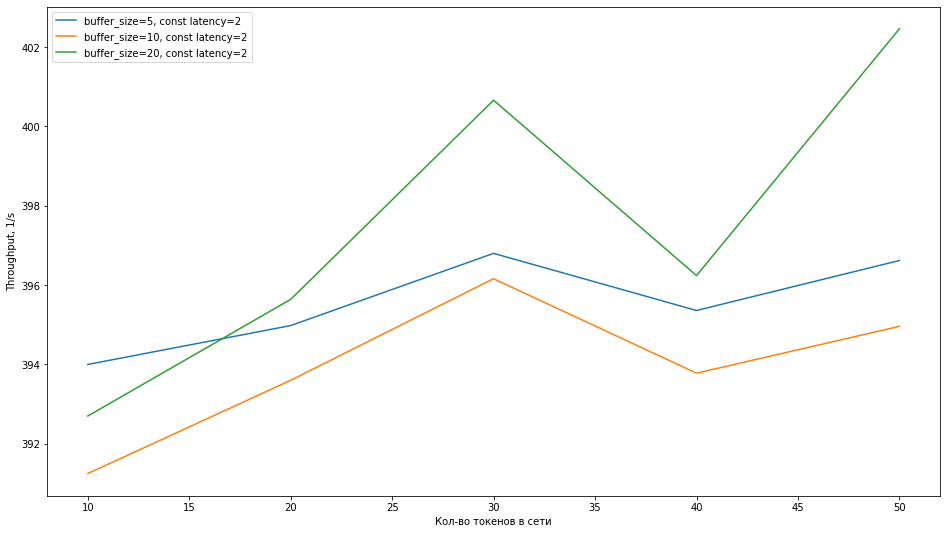

In [149]:
avg_tput_5_2 = avg_tputs(5, 2, 6)
avg_tput_10_2 = avg_tputs(10, 2, 6)
avg_tput_20_2 = avg_tputs(20, 2, 6)


fig = plt.figure(figsize=(16, 9))
plt.plot(range(10, 60, 10), avg_tput_5_2, label="buffer_size=5, const latency=2")
plt.plot(range(10, 60, 10), avg_tput_10_2, label="buffer_size=10, const latency=2")
plt.plot(range(10, 60, 10), avg_tput_20_2, label="buffer_size=20, const latency=2")
plt.title("")
plt.xlabel("Кол-во токенов в сети")
plt.ylabel("Throughput, 1/s")
plt.legend()
plt.show()

В случае наличия задержки в узлах, throughput в системах с разными размерами очередей отличается мало, и хоть по графику может показаться, что отличия существенны, на самом деле абсолютные значения пропускной способности систем лежат очень близко и слабо изменяются от нагрузки или размера очереди.

# Заключение:

В результате исследований было выяснено, что размер очередей имеет определенное влияние на обе исследовавшихся харрактеристики, и его увеличение имеет смысл, при условии сохранения количества сообщений в сети. Однако, при появлении в узлах системы задержки на обработку сообщений - latency и throughput изменяются значительно в негативную (в плане использования системы) сторону, при этом изменение нагрузки (что не желательно в рабочей системе) или размеров срединных очередей не позволяет нивелировать данную проблему и система требует пересмотра алгоритма обработки сообщений непосредственно на узлах.